In [13]:
!pip install sgp4 plotly numpy requests

In [24]:
# Import libraries
import requests
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sgp4.api import Satrec
from datetime import datetime, timedelta, timezone

In [22]:
import requests

tle_url = "https://celestrak.org/NORAD/elements/gp.php?GROUP=fengyun-1c-debris&FORMAT=tle"
data = requests.get(tle_url).text.strip().splitlines()

tle_data = []
for i in range(0, len(data), 3):
    name = data[i].strip()
    line1 = data[i+1].strip()
    line2 = data[i+2].strip()
    tle_data.append((name, line1, line2))

print(f"Fetched {len(tle_data)} debris objects")

Fetched 1852 debris objects


In [16]:
tle_url = "https://celestrak.org/NORAD/elements/gp.php?GROUP=fengyun-1c-debris&FORMAT=tle"
data = requests.get(tle_url).text.splitlines()

print("Total lines:", len(data))

Total lines: 5556


In [20]:
now = datetime.now(timezone.utc)
num_objects = 30
positions_list = []
names = []

for i in range(0, num_objects * 3, 3):
    name = data[i].strip()
    line1 = data[i+1].strip()
    line2 = data[i+2].strip()

    sat = Satrec.twoline2rv(line1, line2)
    positions = []

    # simulate 1 orbit (~500 minutes)
    for j in range(0, 500, 20):
        t = now + timedelta(minutes=j)
        # Calculate Julian date from datetime object
        jd = t.toordinal() + 1721424.5 + (t.hour / 24.0) + (t.minute / 1440.0) + (t.second / 86400.0)

        e, r, v = sat.sgp4(jd, 0.0) # Pass Julian date and fraction of day
        if e == 0:
            positions.append(r)

    if len(positions) > 0:
        positions_list.append(positions)
        names.append(name)

print("Debris objects plotted:", len(positions_list))

Debris objects plotted: 30


In [25]:
satellites = []
for name, l1, l2 in tle_data:
    sat = Satrec.twoline2rv(l1, l2)
    inc = sat.inclo * (180/np.pi)          # Inclination in degrees (how tilted the orbit is)
    ecc = sat.ecco                         # Eccentricity (how circular/elliptical it is)
    mm = sat.no_kozai * 60*24/(2*np.pi)    # Mean motion (orbits per day)
    period = 1440 / mm                     # Orbital period in minutes
    alt = (sat.a - 1) * 6371               # Altitude from Earth's center (approx)
    satellites.append([name, inc, ecc, period, alt])

df = pd.DataFrame(satellites, columns=["Name", "Inclination", "Eccentricity", "Period (min)", "Altitude (km)"])
df.head()

,Name,Inclination,Eccentricity,Period (min),Altitude (km)
0,FENGYUN 1C,98.8880,0.001082,100.999259,802.222833
1,FENGYUN 1C DEB,99.2271,0.056673,111.082476,1272.399607
2,FENGYUN 1C DEB,99.1674,0.061039,111.540953,1293.426259
3,FENGYUN 1C DEB,99.3879,0.070222,112.942816,1357.560899
4,FENGYUN 1C DEB,99.4024,0.072752,114.522561,1429.508864


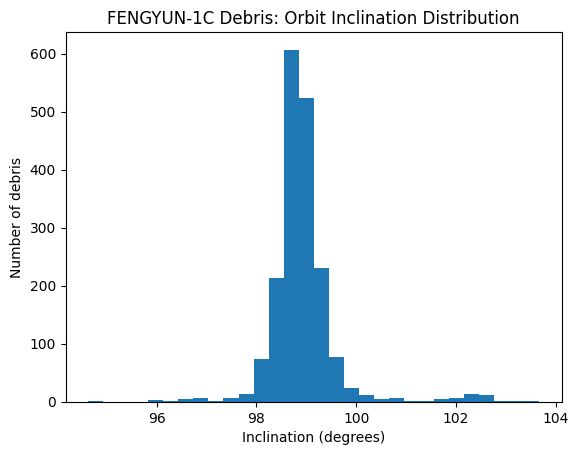

In [26]:
import matplotlib.pyplot as plt

plt.hist(df["Inclination"], bins=30)
plt.xlabel("Inclination (degrees)")
plt.ylabel("Number of debris")
plt.title("FENGYUN-1C Debris: Orbit Inclination Distribution")
plt.show()

In [18]:
import numpy as np
import plotly.graph_objects as go

# Earth sphere
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:25j]
xe = np.cos(u)*np.sin(v)*6371
ye = np.sin(u)*np.sin(v)*6371
ze = np.cos(v)*6371

fig = go.Figure()

# Earth base
fig.add_trace(go.Surface(
    x=xe, y=ye, z=ze,
    colorscale='Blues', opacity=0.5, showscale=False, name='Earth'
))

# Add each debris orbit
for pos, nm in zip(positions_list, names):
    x, y, z = zip(*pos)
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='lines',
        line=dict(width=2),
        opacity=0.6,
        name=nm
    ))

fig.update_layout(
    title="FENGYUN-1C Debris Orbits Around Earth",
    showlegend=False,
    scene=dict(
        xaxis_title='X (km)',
        yaxis_title='Y (km)',
        zaxis_title='Z (km)',
        aspectmode='data'
    )
)

fig.show()

In [27]:
import plotly.graph_objects as go
import numpy as np

earth = go.Scatter3d(
    x=[0], y=[0], z=[0],
    mode="markers",
    marker=dict(size=20, color="blue"),
    name="Earth"
)

orbits = []
for i in range(0, len(df), 20):  # plot fewer for performance
    r = 6371 + df["Altitude (km)"].iloc[i]
    inc = np.radians(df["Inclination"].iloc[i])
    theta = np.linspace(0, 2*np.pi, 100)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = r * np.sin(inc) * np.sin(theta)
    orbits.append(go.Scatter3d(x=x, y=y, z=z, mode="lines", name=df["Name"].iloc[i], line=dict(width=1)))

fig = go.Figure(data=[earth] + orbits)
fig.update_layout(title="3D Visualization of FENGYUN-1C Debris Orbits", template="plotly_dark")
fig.show()

In [28]:
print(f"Total debris objects analyzed: {len(df)}")
print(f"Average altitude: {df['Altitude (km)'].mean():.2f} km")
print(f"Average orbital period: {df['Period (min)'].mean():.2f} minutes")
print(f"Mean inclination: {df['Inclination'].mean():.2f}°")

Total debris objects analyzed: 1852
Average altitude: 827.29 km
Average orbital period: 101.54 minutes
Mean inclination: 98.92°
